1. Landasan Teori

    1.   Pengertian Analisis Data, Analisis data adalah Analisis data adalah proses mengolah data mentah menjadi informasi yang bermakna. Perannya krusial dalam keputusan bisnis (seperti segmentasi pelanggan Olist ini) agar strategi pemasaran tidak berdasarkan asumsi, melainkan bukti empiris (data-driven). sederhananya Analisis Data ini adalah mengubah raw data menjadi suatu informasi.

    2.   Perbedaan Descriptive Analysis dan EDA

          •	Descriptive Analysis: Menjelaskan apa yang telah terjadi di masa lalu (contoh: rata-rata belanja pelanggan adalah R$ 126.63).

          •	EDA: adalah proses mencari pola baru dari data yang telah dipelajari(data latih), misal di projek ini EDA menemukan bahwa sebagian besar pelanggan hanya melakukan satu kali transaksi melalui visualisasi distribusi.

    3.   Pentingnya Data Cleaning dan Data Wrangling
    Data mentah seringkali ada yang terduplikat, kosong atapun mengandung pesanan yang dibatalkan. Proses cleaning (seperti memfilter status 'delivered') memastikan bahwa insight yang diambil hanya berasal dari transaksi yang sukses, sehingga hasil analisis akurat.

    4.   Peran Visualisasi Data
    Visualisasi dipergunakan untuk menggambarkan data yang ada secara sederhana guna kebutuhan analisa. Contohnya, menggunakan scatter plot untuk melihat pengelompokan cluster pelanggan secara intuitif.



    5.   Machine Learning: K-Means Clustering
    Saya menggunakan teknik Unsupervised Learning: K-Means Clustering. Alasan penggunaannya adalah karena dataset pelanggan e-commerce sangat besar dan tidak memiliki label kategori sebelumnya (Unsupervised). K-Means bisa membantu mengelompokkan pelanggan secara otomatis berdasarkan kemiripan profil RFM (Recency, Frequency, Monetary).

2. Implementasi Proyek

    a. Data Preparation

    menggabungkan tiga dataset utama: orders, items, dan customers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Memuat Dataset dengan Penanganan Error
# Parameter on_bad_lines='skip' akan melewati baris yang memiliki kolom berlebih
try:
    orders = pd.read_csv('orders_dataset.csv', on_bad_lines='skip')
    items = pd.read_csv('order_items_dataset.csv', on_bad_lines='skip')
    customers = pd.read_csv('customers_dataset.csv', on_bad_lines='skip')
    print("Dataset berhasil dimuat!")
except Exception as e:
    print(f"Gagal memuat dataset: {e}")

# 2. Data Wrangling (Merging)
# Menggabungkan data pesanan, item produk, dan informasi pelanggan
df = pd.merge(orders, items, on='order_id')
df = pd.merge(df, customers, on='customer_id')

# 3. Data Cleaning
# Mengonversi kolom tanggal ke format datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Menghilangkan data yang status pesanan-nya tidak 'delivered'
df = df[df['order_status'] == 'delivered'].copy()

# Menangani missing values dan duplikasi
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# 4. Transformasi Data (RFM Analysis)
# Menentukan tanggal referensi (hari terakhir di data + 1)
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Agregasi untuk RFM
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days, # Recency
    'order_id': 'count', # Frequency
    'price': 'sum'       # Monetary
})

# Rename kolom
rfm.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'price': 'Monetary'
}, inplace=True)

# Tambahan: Menghapus outlier pada Monetary agar visualisasi lebih baik
# Pelanggan dengan belanja sangat ekstrim dapat mengganggu clustering
rfm = rfm[rfm['Monetary'] < rfm['Monetary'].quantile(0.99)]

print("\nStruktur Data RFM (Siap untuk Machine Learning):")
display(rfm.head())

# 5. Implementasi Machine Learning (K-Means)
# Standarisasi data agar skala Recency, Frequency, dan Monetary setara
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Membuat model K-Means dengan 3 cluster (Contoh: Loyal, Potensial, Berisiko)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("\nHasil Clustering:")
display(rfm.groupby('Cluster').mean())

# Simpan hasil untuk Dashboard Streamlit
rfm.to_csv('rfm_result.csv', index=True)
print("\nFile 'rfm_result.csv' berhasil disimpan untuk deployment!")

Dataset berhasil dimuat!

Struktur Data RFM (Siap untuk Machine Learning):


,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
0000f46a3911fa3c0805444483337064,537,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
0004aac84e0df4da2b147fca70cf8255,288,1,180.00



Hasil Clustering:


,Recency,Frequency,Monetary
Cluster,,,
0,389.457399,1.080774,99.072607
1,225.541596,2.180010,417.681463
2,128.335949,1.073588,97.078737



File 'rfm_result.csv' berhasil disimpan untuk deployment!


b. Exploratory Data Analysis (EDA)

    *   Distribusi Belanja: Rata-rata pelanggan menghabiskan R$ 126.63, namun median (50%) berada di angka R$ 89.00, menunjukkan adanya kemiringan distribusi data (right-skewed).

    *   Frekuensi: Rata-rata frekuensi pembelian hanya 1.18 kali. Ini adalah angka yang rendah, menunjukkan tingkat retention yang perlu diperbaiki.


In [3]:
# 1. Analisis Statistik Deskriptif
print("\nStatistik Deskriptif RFM:")
display(rfm.describe())

# 2. Menjawab Pertanyaan Bisnis
# Pertanyaan 1: Bagaimana distribusi pelanggan berdasarkan total uang yang dihabiskan?
# Pertanyaan 2: Berapa rata-rata frekuensi pembelian pelanggan di platform ini?

print(f"Rata-rata frekuensi pembelian: {rfm['Frequency'].mean():.2f} kali")


Statistik Deskriptif RFM:


,Recency,Frequency,Monetary,Cluster
count,92392.000000,92392.000000,92392.000000,92392.000000
mean,237.902113,1.175686,126.629134,1.137869
std,152.533990,0.587932,133.969376,0.944051
min,1.000000,1.000000,0.850000,0.000000
25%,114.000000,1.000000,46.990000,0.000000
50%,219.000000,1.000000,89.000000,2.000000
75%,346.000000,1.000000,149.990000,2.000000
max,714.000000,21.000000,1001.000000,2.000000


Rata-rata frekuensi pembelian: 1.18 kali


c. Visualisasi Data

    *   Recency Plot: Menunjukkan kapan terakhir pelanggan bertransaksi.

    *   Scatter Plot Frequency vs Monetary: Memperlihatkan bahwa pelanggan dengan frekuensi tinggi (loyal) cenderung menyumbang nilai moneter yang jauh lebih besar.


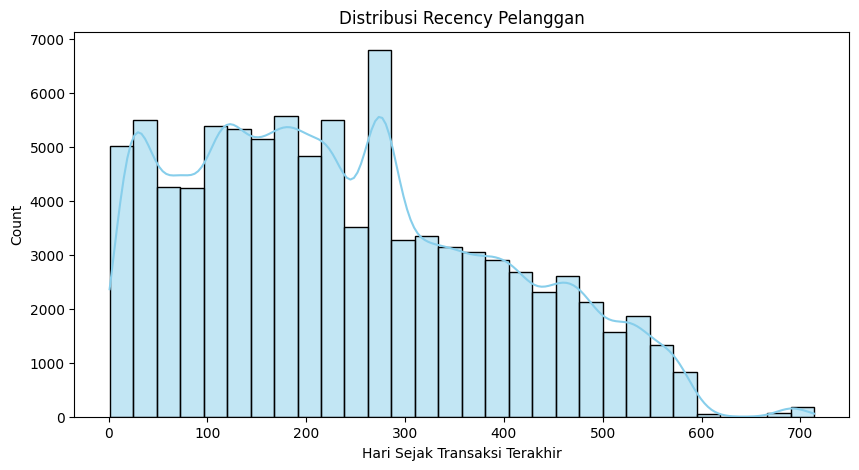

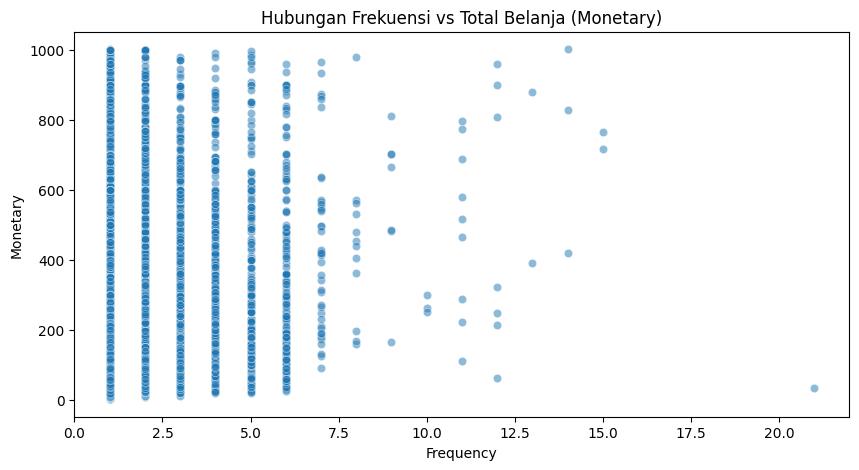

In [4]:
# Visualisasi 1: Distribusi Recency (Berapa lama sejak pembelian terakhir)
plt.figure(figsize=(10, 5))
sns.histplot(rfm['Recency'], bins=30, color='skyblue', kde=True)
plt.title('Distribusi Recency Pelanggan')
plt.xlabel('Hari Sejak Transaksi Terakhir')
plt.show()

# Visualisasi 2: Korelasi Frequency vs Monetary
plt.figure(figsize=(10, 5))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', alpha=0.5)
plt.title('Hubungan Frekuensi vs Total Belanja (Monetary)')
plt.show()

d. Machine Learning (K-Means Clustering)

Berdasarkan hasil pengelompokan (K-Means), bisa diberikan label pada 3 cluster tersebut:

1.   Cluster 1:

    *   Karakteristik: Recency Rendah (128 hari), Freq, Monetary Rendah.

    *   Label bisnis: Pelanggan Baru/ Aktif

    *   Strategi: Berikan promo untuk pembelian kedua.


2.   Cluster 0:

    *   Karakteristik: Recency Tinggi (389 hari), Freq Rendah, Monetary Rendah

    *   Label bisnis: Pelanggan Berisiko (Churn)

    *   Strategi: Kirim email re-engagement atau diskon "Win-back".
    

3.   Cluster 2:

    *   Karakteristik: Recency Sedang (225 hari), Freq Tinggi (2.18), Monetary Tinggi

    *   Label bisnis: Pelanggan Loyal/ VIP

    *   Strategi: Masukkan ke program eksklusif (Loyalty Program).
    





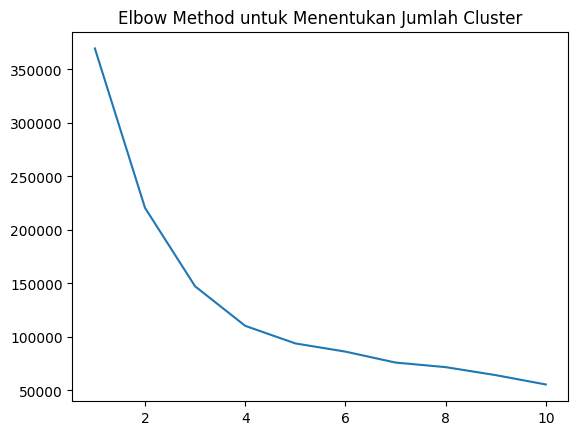


Analisis Karakteristik Per Cluster:


Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        389.46      1.08    99.07  35680
1        128.34      1.07    97.08  48418
2        225.54      2.18   417.68   8294

e. Insight & Kesimpulan Strategis


1. Ringkasan Temuan (Insight)
    
    **Dominasi Pelanggan Transaksional**: Berdasarkan data EDA, rata-rata frekuensi pembelian berada di angka 1.18, yang berarti mayoritas pelanggan hanya melakukan satu kali transaksi. Platform ini memiliki tantangan besar dalam membangun kesetiaan pelanggan (customer retention).

    **Korelasi Recency & Revenue:** Terdapat pola di mana pelanggan yang baru saja bertransaksi (Recency rendah) memiliki potensi nilai moneter yang lebih stabil. Sebaliknya, pelanggan di Cluster 0 (35.680 orang) sudah tidak aktif selama lebih dari satu tahun (>380 hari).

   **Identifikasi Kelompok VIP**: Melalui Machine Learning, kita berhasil
    mengidentifikasi Cluster 2 sebagai kelompok paling berharga. Meskipun jumlahnya paling sedikit (8.294 orang), mereka memiliki rata-rata belanja mencapai R$ 417.68, jauh di atas rata-rata platform (R$ 126.63).


2. Kesimpulan & Rekomendasi Bisnis

    Berdasarkan segmentasi yang terbentuk, berikut adalah strategi yang direkomendasikan:

    **Strategi Retensi (Cluster 1 - Baru/Aktif):** Fokus pada nurturing. Kirimkan voucher diskon untuk pembelian kedua dalam waktu 30 hari setelah transaksi pertama untuk membiasakan mereka berbelanja di platform.

   **Strategi Re-engagement (Cluster 0 - Berisiko)**: Karena mereka sudah lama tidak aktif, lakukan kampanye "We Miss You" dengan penawaran khusus yang sangat menarik untuk memicu mereka kembali ke aplikasi.

    **Strategi Loyalitas (Cluster 2 - VIP):** Ini adalah aset terbesar perusahaan. Berikan akses awal ke produk baru, layanan bebas ongkir tanpa syarat, atau poin loyalitas yang dapat ditukar untuk menjaga mereka tetap di ekosistem Olist.


